### Import necessary libraries

In [113]:
import os
import sys
import torch
import optuna
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import polars as pl

sys.path.append('../..')
from src.utils import load_env_vars


In [114]:
import warnings
warnings.filterwarnings("ignore")

### Device for inference

In [115]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cuda for inference


### Reproducibility

In [116]:
def seed_everything(seed : int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

### Global variables

In [117]:
DATA_DIR, _, _ = load_env_vars()

In [118]:
N_SPLITS = 5
N_NEGATIVE = 91700
LGB_WEIGHTS = 0.4
CB_WEIGHTS = 0.6
EARLY_STOPPING_ROUNDS = 30

In [119]:
SEED = 42
seed_everything(SEED)

### Algorithms Params

In [120]:
### LightGBM parameters
lgb_params = {
    'seed': SEED,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'min_child_samples': 48,
    'num_iterations': 3000,
    'learning_rate': 0.03,
    'extra_trees': True,
    'metric': 'binary_logloss',
    'reg_alpha': 0.1,
    'reg_lambda': 0.8,
    'num_leaves': 64,
    'device': 'gpu',
    'max_bin': 128,
    'max_depth': 4,
    'verbose': -1
}

### CatBoost parameters
cb_params = {
    'random_seed': SEED,
    'grow_policy': 'Depthwise',
    'loss_function': 'Logloss',
    'min_child_samples': 48,
    'learning_rate': 0.03,
    'task_type': 'GPU',
    'reg_lambda': 0.8,
    'num_trees': 3000,
    'depth': 4
}

### Data loading

In [121]:
train_meta_path = os.path.join(DATA_DIR, 'isic_2024/train-metadata.csv')
test_meta_path = os.path.join(DATA_DIR, 'isic_2024/test-metadata.csv')

In [122]:
train_metadata = pd.read_csv(train_meta_path)
test_metadata = pd.read_csv(test_meta_path)
train_metadata.head().T

,0,1,2,3,4
isic_id,ISIC_0015670,ISIC_0015845,ISIC_0015864,ISIC_0015902,ISIC_0024200
target,0,0,0,0,0
patient_id,IP_1235828,IP_8170065,IP_6724798,IP_4111386,IP_8313778
age_approx,60.0,60.0,60.0,65.0,55.0
sex,male,male,male,male,male
anatom_site_general,lower extremity,head/neck,posterior torso,anterior torso,anterior torso
clin_size_long_diam_mm,3.04,1.1,3.4,3.22,2.73
image_type,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up
tbp_tile_type,3D: white,3D: white,3D: XP,3D: XP,3D: white
tbp_lv_A,20.244422,31.71257,22.57583,14.242329,24.72552


In [123]:
train_metadata['age_approx'] = train_metadata['age_approx'].fillna(-1)

### Columns

In [124]:
# Included only on train metadata
train_only_columns = ['lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence']

# Train and Test Features
general_features = ['age_approx', 'sex', 'tbp_tile_type']
color_features = ['tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_norm_color', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt']
shape_features = ['clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'tbp_lv_perimeterMM', 'tbp_lv_area_perim_ratio', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM']
location_features = ['anatom_site_general', 'tbp_lv_location', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z']
additional_features = ['tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'attribution']
target = 'target'
group_col = 'patient_id'

# Drop features
drop_features = ['isic_id', 'image_type', 'copyright_license', 'tbp_lv_location_simple'] + train_only_columns

In [125]:
# 1 if lesion_id is not Nan else 0
train_metadata['lesion_id'] = train_metadata['lesion_id'].notnull().astype(int)

### Downsampling

In [126]:
positive_samples = train_metadata[train_metadata['target'] == 1]
negative_samples = train_metadata[train_metadata['target'] == 0].sample(n=N_NEGATIVE, random_state=SEED)

#df = pd.concat([positive_samples, negative_samples], axis=0).reset_index(drop=True)

df = train_metadata.copy()



### Feature engineering and aggregation

In [127]:
import math as m

def aggregate_features(df):
    columns = []
    ### Ratio Aggregations ###

    df = pl.DataFrame(df)
        
    df = df.with_columns([
        
        # Ratio of A* to the product of A*ext and age minimum A*
        pl.col('tbp_lv_A').truediv(pl.col('tbp_lv_Aext').mul(pl.col('tbp_lv_A').min()))
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_ratio_A'),
        
        # Ratio of B* to the product of B*ext and age minimum B*
        pl.col('tbp_lv_B').truediv(pl.col('tbp_lv_Bext').mul(pl.col('tbp_lv_B').min()))
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_ratio_B'),
        
        # Ratio of C* to the product of C*ext and age minimum C*
        pl.col('tbp_lv_C').truediv(pl.col('tbp_lv_Cext').mul(pl.col('tbp_lv_C').min()))
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_ratio_C'),
        
        # Ratio of H* to the product of H*ext and age minimum H*
        pl.col('tbp_lv_H').truediv(pl.col('tbp_lv_Hext').mul(pl.col('tbp_lv_H').min()))
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_ratio_H'),
        
        # Ratio of L* to the product of L*ext and age minimum L*
        pl.col('tbp_lv_L').truediv(pl.col('tbp_lv_Lext').mul(pl.col('tbp_lv_L').min()))
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_ratio_L'),
        
    ])
    
    df = df.with_columns([
        
        # Contrast between A* and A*ext
        pl.col('tbp_lv_A').sub(pl.col('tbp_lv_Aext'))
        .cast(pl.Float32).alias('tbp_lv_contrast_A'),
        
        # Contrast between B* and B*ext
        pl.col('tbp_lv_B').sub(pl.col('tbp_lv_Bext'))
        .cast(pl.Float32).alias('tbp_lv_contrast_B'),
        
        # Contrast between C* and C*ext
        pl.col('tbp_lv_C').sub(pl.col('tbp_lv_Cext'))
        .cast(pl.Float32).alias('tbp_lv_contrast_C'),
        
        # Contrast between H* and H*ext
        pl.col('tbp_lv_H').sub(pl.col('tbp_lv_Hext'))
        .cast(pl.Float32).alias('tbp_lv_contrast_H'),
        
        # Contrast between L* and L*ext
        pl.col('tbp_lv_L').sub(pl.col('tbp_lv_Lext'))
        .cast(pl.Float32).alias('tbp_lv_contrast_L'), 
        
    ])
    
    df = df.with_columns([     
        
        # Ratio of tbp_lv_ratio_A to patient average
        pl.col('tbp_lv_ratio_A').truediv(pl.col('tbp_lv_ratio_A').mean())
        .over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_ratio_A'),
        
        # Ratio of tbp_lv_ratio_B to patient average
        pl.col('tbp_lv_ratio_B').truediv(pl.col('tbp_lv_ratio_B').mean())
        .over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_ratio_B'),
        
        # Ratio of tbp_lv_ratio_C to patient average
        pl.col('tbp_lv_ratio_C').truediv(pl.col('tbp_lv_ratio_C').mean())
        .over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_ratio_C'),
        
        # Ratio of tbp_lv_ratio_H to patient average
        pl.col('tbp_lv_ratio_H').truediv(pl.col('tbp_lv_ratio_H').mean())
        .over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_ratio_H'),
        
        # Ratio of tbp_lv_ratio_L to patient average
        pl.col('tbp_lv_ratio_L').truediv(pl.col('tbp_lv_ratio_L').mean())
        .over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_ratio_L'),
        
    ])
    
    df = df.with_columns([     
        
        # Ratio of tbp_lv_contrast_A to patient average
        pl.col('tbp_lv_contrast_A').truediv(pl.col('tbp_lv_contrast_A').mean())
        .over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_contrast_A'),
        
        # Ratio of tbp_lv_contrast_B to patient average
        pl.col('tbp_lv_contrast_B').truediv(pl.col('tbp_lv_contrast_B').mean())
        .over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_contrast_B'),
        
        # Ratio of tbp_lv_contrast_C to patient average
        pl.col('tbp_lv_contrast_C').truediv(pl.col('tbp_lv_contrast_C').mean())
        .over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_contrast_C'),
        
        # Ratio of tbp_lv_contrast_H to patient average
        pl.col('tbp_lv_contrast_H').truediv(pl.col('tbp_lv_contrast_H').mean())
        .over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_contrast_H'),
        
        # Ratio of tbp_lv_contrast_L to patient average
        pl.col('tbp_lv_contrast_L').truediv(pl.col('tbp_lv_contrast_L').mean())
        .over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_contrast_L'),
        
    ])
    
    df = df.with_columns([     
        
        # Ratio of tbp_lv_ratio_A to age average
        pl.col('tbp_lv_ratio_A').truediv(pl.col('tbp_lv_ratio_A').mean())
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_ratio_A'),
        
        # Ratio of tbp_lv_ratio_B to age average
        pl.col('tbp_lv_ratio_B').truediv(pl.col('tbp_lv_ratio_B').mean())
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_ratio_B'),
        
        # Ratio of tbp_lv_ratio_C to age average
        pl.col('tbp_lv_ratio_C').truediv(pl.col('tbp_lv_ratio_C').mean())
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_ratio_C'),
        
        # Ratio of tbp_lv_ratio_H to age average
        pl.col('tbp_lv_ratio_H').truediv(pl.col('tbp_lv_ratio_H').mean())
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_ratio_H'),
        
        # Ratio of tbp_lv_ratio_L to age average
        pl.col('tbp_lv_ratio_L').truediv(pl.col('tbp_lv_ratio_L').mean())
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_ratio_L'),
        
    ])
    
    df = df.with_columns([     
        
        # Ratio of tbp_lv_contrast_A to age average
        pl.col('tbp_lv_contrast_A').truediv(pl.col('tbp_lv_contrast_A').mean())
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_contrast_A'),
        
        # Ratio of tbp_lv_contrast_B to age average
        pl.col('tbp_lv_contrast_B').truediv(pl.col('tbp_lv_contrast_B').mean())
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_contrast_B'),
        
        # Ratio of tbp_lv_contrast_C to age average
        pl.col('tbp_lv_contrast_C').truediv(pl.col('tbp_lv_contrast_C').mean())
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_contrast_C'),
        
        # Ratio of tbp_lv_contrast_H to age average
        pl.col('tbp_lv_contrast_H').truediv(pl.col('tbp_lv_contrast_H').mean())
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_contrast_H'),
        
        # Ratio of tbp_lv_contrast_L to age average
        pl.col('tbp_lv_contrast_L').truediv(pl.col('tbp_lv_contrast_L').mean())
        .over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_contrast_L'),
        
    ])

    ###############
    
    df = df.with_columns([
        # Compactness (ratio of area to perimeter squared)
        (pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2))
        .cast(pl.Float32).alias('tbp_lv_compactness'),
        
        # Color channel ratios (assuming RGB color space)
        (pl.col('tbp_lv_A') / pl.col('tbp_lv_B'))
        .cast(pl.Float32).alias('tbp_lv_color_ratio_AB'),
        
        # Contrast ratio between lesion and surrounding
        ((pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')) / (pl.col('tbp_lv_L') + pl.col('tbp_lv_Lext')))
        .cast(pl.Float32).alias('tbp_lv_contrast_ratio'),
        
        # Interaction between age and lesion size
        (pl.col('age_approx') * pl.col('tbp_lv_areaMM2'))
        .cast(pl.Float32).alias('tbp_lv_age_size_interaction'),
        
        # Texture complexity (using standard deviation of L as a proxy)
        (pl.col('tbp_lv_stdL') / pl.col('tbp_lv_L'))
        .cast(pl.Float32).alias('tbp_lv_texture_complexity'),
        
        # Border irregularity (using area to perimeter ratio as a proxy)
        (pl.col('tbp_lv_perimeterMM') / (2 * ( m.pi * pl.col('tbp_lv_areaMM2')).sqrt()))
        .cast(pl.Float32).alias('tbp_lv_border_irregularity'),
        
        # Color asymmetry (difference between left and right halves)
        (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs()
        .cast(pl.Float32).alias('tbp_lv_color_asymmetry'),
        
        # Relative size (compared to average lesion size for the anatomical site)
        (pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_areaMM2').mean().over('anatom_site_general'))
        .cast(pl.Float32).alias('tbp_lv_relative_size'),
    ])
    
    # Multi-scale features (example using different area ratios)
    df = df.with_columns([
        # Area ratio using minor axis
        (pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_minorAxisMM') ** 2)).over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_area_ratio_minor'),

        # Area ratio using major axis
        (pl.col('tbp_lv_areaMM2') / (pl.col('clin_size_long_diam_mm') ** 2)).over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_area_ratio_major'),

        # Area ratio using both minor and major axes
        (pl.col('tbp_lv_areaMM2') / (pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_minorAxisMM'))).over('patient_id')
        .cast(pl.Float32).alias('tbp_lv_patient_area_ratio_full'),

        # Area ratio using minor axis
        (pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_minorAxisMM') ** 2)).over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_area_ratio_minor'),

        # Area ratio using major axis
        (pl.col('tbp_lv_areaMM2') / (pl.col('clin_size_long_diam_mm') ** 2)).over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_area_ratio_major'),

        # Area ratio using both minor and major axes
        (pl.col('tbp_lv_areaMM2') / (pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_minorAxisMM'))).over('age_approx')
        .cast(pl.Float32).alias('tbp_lv_age_area_ratio_full'),

    ]) 


    # Nevi confidence aggregations
    df = df.with_columns([
        
        # Average nevi confidence for the age group
        pl.col('tbp_lv_nevi_confidence').mean().over('age_approx')
        .cast(pl.Float32).alias('age_mean_nevi_confidence'),

        # Average nevi confidence for the patient
        pl.col('tbp_lv_nevi_confidence').mean().over('patient_id')
        .cast(pl.Float32).alias('patient_mean_nevi_confidence'),
    ])

    
    # Count-based features
    df = df.with_columns([
        # Number of lesions for the patient
        pl.col('patient_id').count().over('patient_id')
        .cast(pl.Int32).alias('patient_lesion_count'),
    ])
    

    columns += ['tbp_lv_ratio_A', 'tbp_lv_ratio_B', 'tbp_lv_ratio_C', 'tbp_lv_ratio_H', 'tbp_lv_ratio_L']
    columns += ['tbp_lv_contrast_A', 'tbp_lv_contrast_B', 'tbp_lv_contrast_C', 'tbp_lv_contrast_H', 'tbp_lv_contrast_L']
    columns += ['tbp_lv_patient_ratio_A', 'tbp_lv_patient_ratio_B', 'tbp_lv_patient_ratio_C', 'tbp_lv_patient_ratio_H', 'tbp_lv_patient_ratio_L']
    columns += ['tbp_lv_patient_contrast_A', 'tbp_lv_patient_contrast_B', 'tbp_lv_patient_contrast_C', 'tbp_lv_patient_contrast_H', 'tbp_lv_patient_contrast_L']
    columns += ['tbp_lv_age_ratio_A', 'tbp_lv_age_ratio_B', 'tbp_lv_age_ratio_C', 'tbp_lv_age_ratio_H', 'tbp_lv_age_ratio_L']
    columns += ['tbp_lv_age_contrast_A', 'tbp_lv_age_contrast_B', 'tbp_lv_age_contrast_C', 'tbp_lv_age_contrast_H', 'tbp_lv_age_contrast_L']
    
    columns += ['tbp_lv_compactness', 'tbp_lv_color_ratio_AB', 'tbp_lv_contrast_ratio', 'tbp_lv_age_size_interaction', 'tbp_lv_texture_complexity', 'tbp_lv_border_irregularity', 'tbp_lv_color_asymmetry', 'tbp_lv_relative_size']
    columns += ['tbp_lv_patient_area_ratio_minor', 'tbp_lv_patient_area_ratio_major', 'tbp_lv_patient_area_ratio_full', 'tbp_lv_age_area_ratio_minor', 'tbp_lv_age_area_ratio_major', 'tbp_lv_age_area_ratio_full']
    columns += ['age_mean_nevi_confidence', 'patient_mean_nevi_confidence']
    columns += ['patient_lesion_count']


    return df, columns

In [128]:
df, new_cols = aggregate_features(df)
df = df.to_pandas()

In [129]:
df.shape

(401059, 102)

### Encoding

In [130]:
train_cols = general_features + color_features + shape_features + location_features + additional_features + new_cols
categorical_cols = df[train_cols].select_dtypes(include=['object']).columns
num_features = df[train_cols].select_dtypes(include=[np.number]).columns

# cast numerical columns to float32
df[num_features] = df[num_features].astype('float32')

In [131]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

sex                     11517
anatom_site_general      5756
iddx_2                 399991
iddx_3                 399994
iddx_4                 400508
iddx_5                 401058
mel_mitotic_index      401006
mel_thick_mm           400996
dtype: int64

In [132]:
df[categorical_cols] = df[categorical_cols].fillna('missing')

### Partial AUC

In [133]:
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score

def pauc_score(solution: pd.DataFrame, submission: pd.DataFrame, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''



    # check submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ValueError("Expected numeric values in submission, got: %r" % submission.values)
    
    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*np.asarray(submission.values)

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)

### Cross Validation Setup

In [134]:
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
"""
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(sgkf.split(df, df[target], df[group_col])):
    df.loc[val_idx, 'fold'] = fold
"""

"\ndf['fold'] = -1\nfor fold, (train_idx, val_idx) in enumerate(sgkf.split(df, df[target], df[group_col])):\n    df.loc[val_idx, 'fold'] = fold\n"

### LightGBM Training

In [135]:
"""
def objective(trial: optuna.Trial) -> float:
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
        'gama': trial.suggest_float('gama', 1e-8, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0, step=0.1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0, step=0.1),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 1e-8, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_bin': trial.suggest_int('max_bin', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000, step=1000),
        'n_jobs': -1,
        'random_state': SEED
    }

    scores = []

    for fold in tqdm(range(N_SPLITS)):
        # Split data
        train_df = df[df['fold'] != fold].reset_index(drop=True)
        val_df = df[df['fold'] == fold].reset_index(drop=True)

        X_train, y_train = train_df[train_cols], train_df[target]
        X_val, y_val = val_df[train_cols], val_df[target]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

        y_pred = model.predict_proba(X_val)[:, 1]

        score = pauc_score(val_df[[target]], pd.DataFrame(y_pred, columns=['prediction']), '')
        print(f'Fold {fold} - PAUC: {score}')
        
        scores.append(score)


    return sum(scores) / len(scores)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'lambda_l1': 0.004,
    'lambda_l2': 8.7,
    'num_leaves': 136,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.9,
    'bagging_freq': 6,
    'min_child_samples': 60,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'device': 'gpu',
    'random_state': SEED
}

scores = []
models = []

for fold in tqdm(range(N_SPLITS)):
    # Split data
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    val_df = df[df['fold'] == fold].reset_index(drop=True)

    X_train, y_train = train_df[train_cols], train_df[target]
    X_val, y_val = val_df[train_cols], val_df[target]

    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict_proba(X_val)[:, 1]
    score = pauc_score(val_df[[target]], pd.DataFrame(y_pred, columns=['prediction']))

    print(f'Fold {fold+1} - PAUC: {score}')
    
    scores.append(score)
    models.append(model)
"""

"\ndef objective(trial: optuna.Trial) -> float:\n    params = {\n        'objective': 'binary',\n        'boosting_type': 'gbdt',\n        'verbosity': -1,\n        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),\n        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),\n        'gama': trial.suggest_float('gama', 1e-8, 10.0),\n        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),\n        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),\n        'num_leaves': trial.suggest_int('num_leaves', 2, 256),\n        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0, step=0.1),\n        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0, step=0.1),\n        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),\n        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),\n        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 1e-8, 1.0),\n        'min_data_in_leaf': trial.suggest_

In [144]:
import joblib

splits = joblib.load(os.path.join(DATA_DIR, 'isic_2024/splits.pkl'))

In [145]:
def train(data, cat_cols, train_cols, lgb_params, cb_params, early_stoping_rounds):

    # Convert categorical columns to category type
    for col in cat_cols:
        data[col] = data[col].astype('category')

    # Split features and label
    X = data[train_cols]
    y = data[target]
    groups = data[group_col]

    cat_features = [X.columns.get_loc(col) for col in cat_cols]

    # Initialize variables
    lgb_models = []
    lgb_scores = []
    cb_models = []
    cb_scores = []
    ensemble_scores = []
    lgb_cms = []
    cb_cms = []
    en_cms = []

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(splits):

        print('*'*10 + f' Fold {fold+1} ' + '*'*10)

        # Split data
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        weights = [1.0 if sample == 0 else 5.0 for sample in y_train]

        # Creat LightGBM datasets
        train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
        val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)

        # Create CatBoost pools
        train_pool = Pool(X_train, y_train, cat_features=cat_features)
        valid_pool = Pool(X_val, y_val, cat_features=cat_features)

        # Train LightGBM model
        lgb_model = lgb.train(lgb_params, train_data, valid_sets=[val_data], callbacks=[lgb.early_stopping(early_stoping_rounds, verbose=0), lgb.log_evaluation(0)])

        # Predict validation data
        lgb_pred = lgb_model.predict(X_val)

        # Calculate PAUC
        lgb_score = pauc_score(pd.DataFrame(y_val, columns=['target']), pd.DataFrame(lgb_pred, columns=['prediction']))
        print(f'100% LightGBM - PAUC: {lgb_score}')

        lgb_cms.append(confusion_matrix(y_val, (lgb_pred > 0.5).astype(int)))

        # Initialize CatBoost
        cb_model = CatBoostClassifier(**cb_params, verbose=0)

        # Train CatBoost model
        cb_model.fit(train_pool, 
                  eval_set=valid_pool, 
                  early_stopping_rounds=early_stoping_rounds)

        # Predict validation data
        cb_pred = cb_model.predict_proba(valid_pool)[:, 1]

        # Calculate PAUC
        cb_score = pauc_score(pd.DataFrame(y_val, columns=['target']), pd.DataFrame(cb_pred, columns=['prediction']))
        print(f'100% CatBoost- PAUC: {cb_score}')

        cb_cms.append(confusion_matrix(y_val, (cb_pred > 0.5).astype(int)))

        ensemble_score = pauc_score(pd.DataFrame(y_val, columns=['target']), pd.DataFrame(lgb_pred * LGB_WEIGHTS + cb_pred * CB_WEIGHTS, columns=['prediction']))
        print(f'50% lgb | 50% cb - PAUC: {ensemble_score}')

        en_cms.append(confusion_matrix(y_val, (lgb_pred * LGB_WEIGHTS + cb_pred * CB_WEIGHTS > 0.5).astype(int)))

        # Append model and score
        lgb_models.append(lgb_model)
        lgb_scores.append(lgb_score)
        cb_models.append(cb_model)
        cb_scores.append(cb_score)
        ensemble_scores.append(ensemble_score)

    return lgb_models, lgb_scores, cb_models, cb_scores, ensemble_scores, lgb_cms, cb_cms, en_cms


In [146]:
lgb_models, lgb_scores, cb_models, cb_scores, ensemble_scores, lgb_cms, cb_cms, en_cms = train(df, categorical_cols, train_cols, lgb_params, cb_params, EARLY_STOPPING_ROUNDS)

********** Fold 1 **********
100% LightGBM - PAUC: 0.1734977876360758
100% CatBoost- PAUC: 0.16186580805046677
50% lgb | 50% cb - PAUC: 0.17208974436472343
********** Fold 2 **********
100% LightGBM - PAUC: 0.16522904263563654
100% CatBoost- PAUC: 0.15386567243456953
50% lgb | 50% cb - PAUC: 0.16434593850172752
********** Fold 3 **********
100% LightGBM - PAUC: 0.16134189639465368
100% CatBoost- PAUC: 0.1549412836480263
50% lgb | 50% cb - PAUC: 0.16145733236824697
********** Fold 4 **********
100% LightGBM - PAUC: 0.1654768441676754
100% CatBoost- PAUC: 0.13999840885549908
50% lgb | 50% cb - PAUC: 0.16549837141680493
********** Fold 5 **********
100% LightGBM - PAUC: 0.1680863897104397
100% CatBoost- PAUC: 0.1443984631959623
50% lgb | 50% cb - PAUC: 0.1647949386708699


In [147]:
print(f'LightGBM - PAUC: {np.mean(lgb_scores)} | STD: {np.std(lgb_scores)}')
print(f'CatBoost - PAUC: {np.mean(cb_scores)} | STD: {np.std(cb_scores)}')
print(f'Ensemble - PAUC: {np.mean(ensemble_scores)} | STD: {np.std(ensemble_scores)}')

LightGBM - PAUC: 0.16672639210889623 | STD: 0.004012420976440233
CatBoost - PAUC: 0.1510139272369048 | STD: 0.007828485242142646
Ensemble - PAUC: 0.16563726506447457 | STD: 0.0035072113125819717


### Confusion Matrices

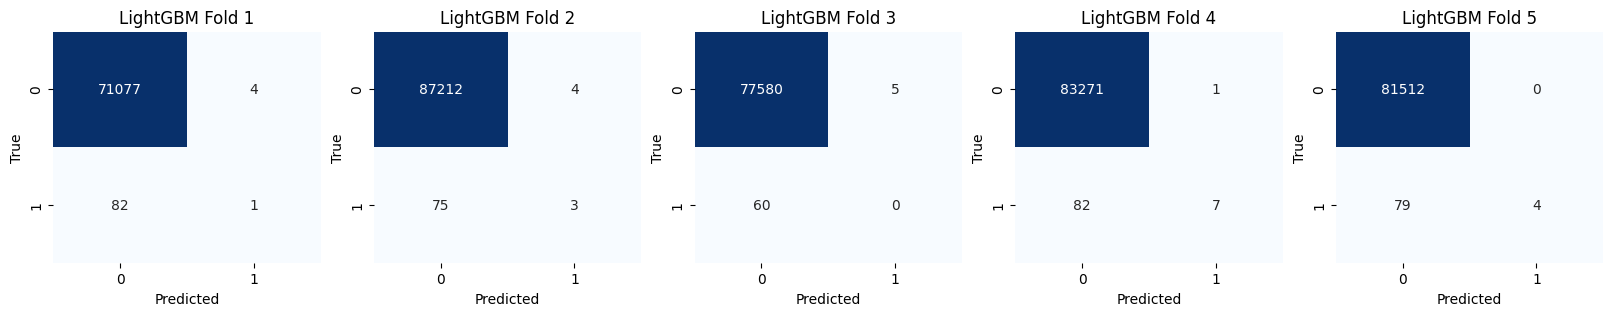

In [ ]:
# LightGBM confusion matrix of each fold
plt.figure(figsize=(20, 3))

for i, cm in enumerate(lgb_cms):
    plt.subplot(1, 5, i+1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'LightGBM Fold {i+1}')

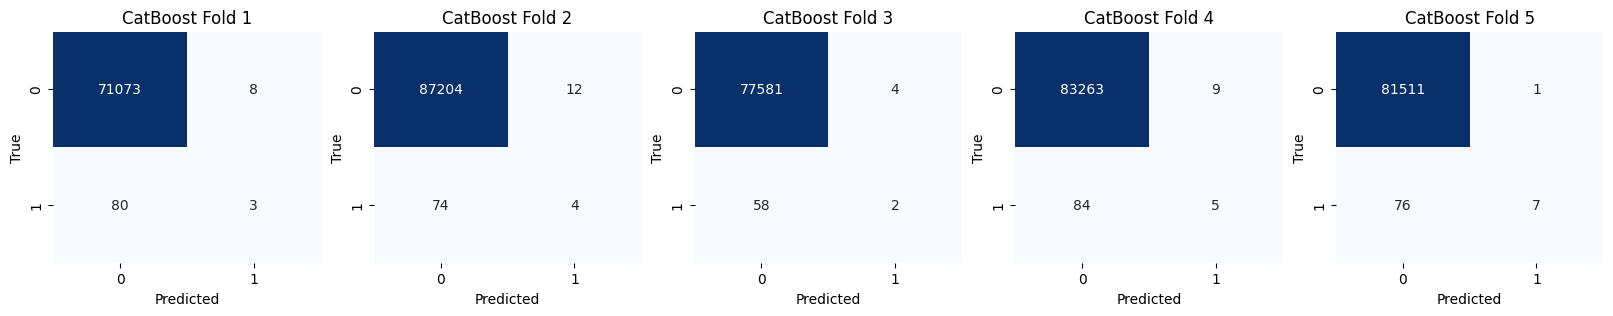

In [ ]:
# CatBoost confusion matrix of each fold
plt.figure(figsize=(20, 3))

for i, cm in enumerate(cb_cms):
    plt.subplot(1, 5, i+1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'CatBoost Fold {i+1}')

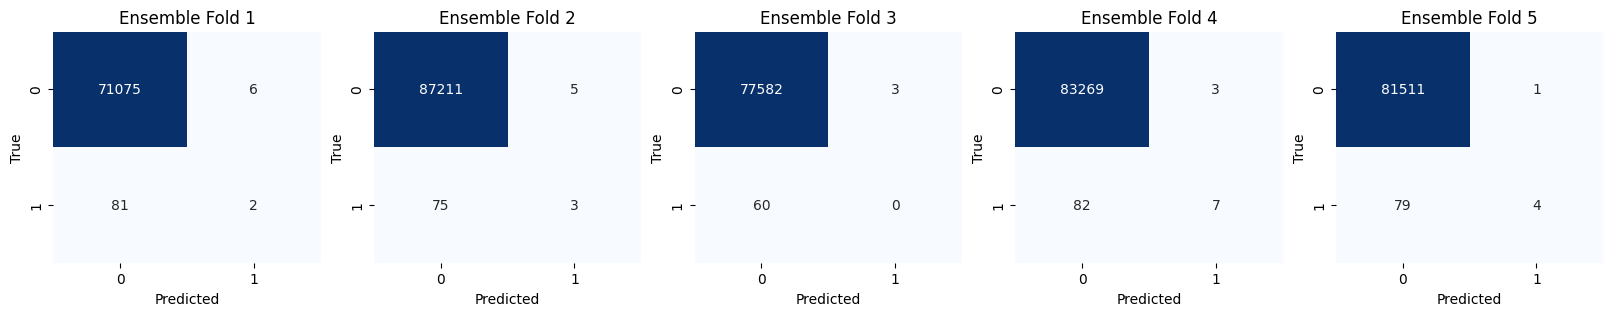

In [ ]:
# Ensemble confusion matrix of each fold
plt.figure(figsize=(20, 3))

for i, cm in enumerate(en_cms):
    plt.subplot(1, 5, i+1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Ensemble Fold {i+1}')